In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccovf
from scipy import signal
from scipy import interpolate

In [2]:
def d(x,y):
    return -np.log(np.exp(-(((x-y)**2+(1e-20)**2)**.5))+np.exp(-(180-((x-y)**2+(1e-20)**2)**.5)))

# gaussian function and stimulus function
def gaussian(x, y, sigma): # Gaussian function centered at y
    return np.exp(-np.power(d(x,y), 2.) / (2 * np.power(sigma, 2.)))

def hfunc(x, phi, sigma_FF): # stimulus of orientation phi
    return gaussian(x, phi, sigma_FF)

In [3]:
# threshold quadratic transfer function
def xfer(k, n, Ialpha):
    return k*(np.power((np.maximum(Ialpha,0)), n))

In [4]:
def integrate(t0, T, dt, phi, N, tau_E, tau_I, J_EE, J_II, J_EI, J_IE, sigma_ori, sigma_FF, k, n, c):
    r_E = np.zeros((N,1)) # firing rate vector of E neurons
    r_I = np.zeros((N,1)) # firing rate vector of I neurons
    zero = np.zeros((N,1)) # Nx1 zero vector
    xs = np.linspace(0, N-1, N)
    
    R_E = r_E # these will store firing rates at each timestep as columns
    R_I = r_I 
    
    G_ori = np.fromfunction(lambda x,y: gaussian(x,y,sigma_ori), (N,N)) # connectivity matrix G
    h = np.array([hfunc(x, phi, sigma_FF) for x in range(N)]) # has shape (180,)
    h = h[:,None] # makes shape (180,1)
    W_EE = J_EE*G_ori
    W_EI = J_EI*G_ori
    W_IE = J_IE*G_ori
    W_II = J_II*G_ori
    
    I_E = c*h + W_EE@r_E + W_EI@r_I # initial inputs 
    I_I = c*h + W_IE@r_E + W_II@r_I
    rE_SS = k*(np.power(np.maximum(I_E, zero), n)) # initial steady state rates
    rI_SS = k*(np.power(np.maximum(I_I, zero), n))
    
    M = int(T/dt)
    ts = np.arange(M+1)
    for m in range(M):
        r_E = r_E + dt*(1/tau_E)*(-r_E + rE_SS)
        r_I = r_I + dt*(1/tau_I)*(-r_I + rI_SS)
        I_E = c*h + W_EE@r_E - W_EI@r_I 
        I_I = c*h + W_IE@r_E - W_II@r_I
        rE_SS = k*(np.power((np.maximum(I_E, zero)), n))
        rI_SS = k*(np.power((np.maximum(I_I, zero)), n))
        R_E = np.c_[R_E, r_E]
        R_I = np.c_[R_I, r_I]
        
    return r_E, r_I, R_E, R_I, xs, ts, c, h, W_EE, W_EI, W_IE, W_II

First, we find the steady-state solution $\mathbf{r}_E^{SS} = \overline{\mathbf{r}}_E$. This is the solution to the system of ODEs in the absence of noise.

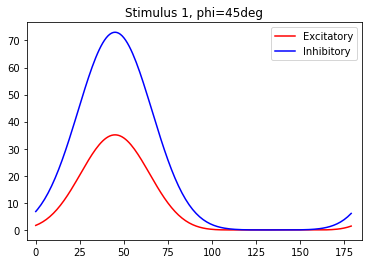

In [5]:
r_E_SS, r_I_SS, R_E_SS, R_I_SS, xs, ts, c, h, W_EE, W_EI, W_IE, W_II = integrate(t0=0, T=500, dt=0.1, phi=45, N=180, tau_E=20, tau_I=10, J_EE=0.044, J_II=0.018, J_EI=0.023, J_IE=0.042, sigma_ori=32, sigma_FF=30, k=0.04, n=2.0, c=40)
plt.plot(xs, r_E_SS, label='Excitatory', color='r')
plt.plot(xs, r_I_SS, label='Inhibitory', color='b')
plt.title('Stimulus 1, phi=45deg')
plt.xlim(-5,185)
plt.legend()
plt.show()

Check out the transfer function:

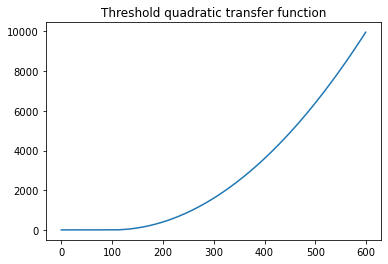

In [6]:
xs = np.arange(-100,500)
plt.plot(xfer(0.04, 2, xs))
plt.title('Threshold quadratic transfer function')
plt.show()

Derivative of transfer function:

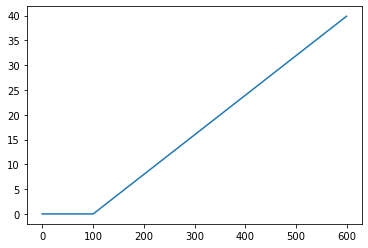

In [7]:
plt.plot(np.diff(xfer(0.04, 2, xs), prepend=0))
plt.show()

We need the derivative of the transfer function in order to compute the linearized system. (Choosing to do the derivative as an interpolation of the numerical derivative since this may allow testing of alternative/more complicated transfer functions in the future.)

In [8]:
df = interpolate.InterpolatedUnivariateSpline(xs, np.diff(xfer(0.04,2,xs), prepend=0))

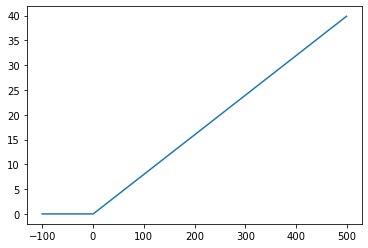

In [9]:
plt.plot(xs, df(xs))
plt.show()

To compute the linearization, we will have to evaluate $\frac{df}{dI}\Bigg|_{I = I_{\alpha, \text{ eff}}}$ where $I_{\alpha, \text{ eff}} = c\mathbf{h} + \mathbf{W}_{\alpha E}\cdot \overline{\mathbf{r}}_E -\mathbf{W}_{\alpha I}\cdot \overline{\mathbf{r}}_I$. Below is what this derivative looks like for $\alpha = E$:

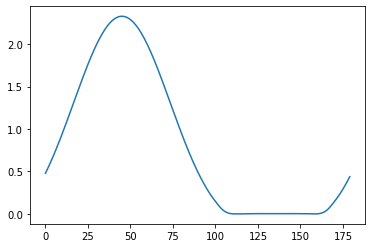

In [10]:
plt.plot(df(c*h + W_EE@r_E_SS - W_EI@r_I_SS))
plt.show()

and for $\alpha = I:$

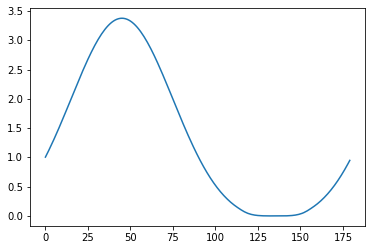

In [11]:
plt.plot(df(c*h + W_IE@r_E_SS - W_II@r_I_SS))
plt.show()

Now we compute the diagonal matrices $\mathbf{L}_E$ and $\mathbf{L}_I$ whose diagonal entries are the derivatives evaluated above.

In [36]:
L_E = np.diagflat(np.array(df(c*h + W_EE@r_E_SS - W_EI@r_I_SS)))
L_I = np.diagflat(np.array(df(c*h + W_IE@r_E_SS - W_II@r_I_SS)))

Next we compute the $\mathbf{W}$ and $\mathbf{D}$ matrices

In [37]:
N = 180
W = np.zeros((2*N, 2*N))
W[:N, :N] = -np.identity(N) + L_E@W_EE
W[N:, :N] = L_I@W_IE
W[:N, N:] = -L_E@W_EI
W[N:, N:] = -np.identity(N) - L_I@W_II
W_inv = np.linalg.inv(W)

In [38]:
D = np.zeros((2*N, 2*N))
D[:N, :N] = c_ne*L_E # c_ne = c_ni = 1, from noisy sim below
D[N:, N:] = c_ni*L_I
D = np.sqrt(2*tau_n)*D # taun = 1, from noisy sim below

Then the long-term covariance matrix is computed $\boldsymbol{\Sigma} = \mathbf{W}^{-1}\mathbf{D}(\mathbf{W}^{-1}\mathbf{D})^T$:

In [39]:
Sigma = W_inv @ D @ ((W_inv@D).T)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_E = Sigma[:N,:N]
Sigma_E_inv = np.linalg.inv(Sigma_E)

In [40]:
pd.DataFrame(Sigma)

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,78.599852,-1.485644,-1.565232,-1.646325,-1.727842,-1.808599,-1.887324,-1.962677,-2.033268,-2.097679,...,0.020025,0.056898,0.093253,0.128725,0.162945,0.195546,0.226162,0.254440,0.280041,0.302645
1,-1.485644,84.187318,-1.651090,-1.737392,-1.824717,-1.911864,-1.997527,-2.080318,-2.158785,-2.231433,...,-0.021917,0.016096,0.053821,0.090887,0.126917,0.161532,0.194357,0.225025,0.253182,0.278491
2,-1.565232,-1.651090,90.037636,-1.832324,-1.925876,-2.019851,-2.112916,-2.203634,-2.290493,-2.371923,...,-0.064187,-0.025507,0.013103,0.051268,0.088607,0.124732,0.159260,0.191814,0.222029,0.249555
3,-1.646325,-1.737392,-1.832324,96.149935,-2.030587,-2.131825,-2.232746,-2.331876,-2.427642,-2.518401,...,-0.106150,-0.067290,-0.028297,0.010455,0.048580,0.085686,0.121384,0.155290,0.187032,0.216250
4,-1.727842,-1.824717,-1.925876,-2.030587,102.522201,-2.246907,-2.356132,-2.464143,-2.569318,-2.669944,...,-0.147148,-0.108601,-0.069733,-0.030919,0.007454,0.044995,0.081311,0.116013,0.148724,0.179079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.195546,0.161532,0.124732,0.085686,0.044995,0.003312,-0.038670,-0.080224,-0.120607,-0.159067,...,0.109320,0.112479,0.112422,0.108875,0.101585,42.944581,0.074957,0.055350,0.031476,0.003352
356,0.226162,0.194357,0.159260,0.121384,0.081311,0.039680,-0.002817,-0.045449,-0.087456,-0.128064,...,0.079314,0.085188,0.087979,0.087387,0.083131,0.074957,46.376222,0.046036,0.025033,-0.000389
357,0.254440,0.225025,0.191814,0.155290,0.116013,0.074607,0.031758,-0.011799,-0.055293,-0.097926,...,0.045751,0.054180,0.059670,0.061897,0.060552,0.055350,0.046036,50.013107,0.014267,-0.008427
358,0.280041,0.253182,0.222029,0.187032,0.148724,0.107713,0.064677,0.020351,-0.024484,-0.069010,...,0.008772,0.019567,0.027574,0.032446,0.033851,0.031476,0.025033,0.014267,53.859443,-0.021012


Plotting the covariance matrix:

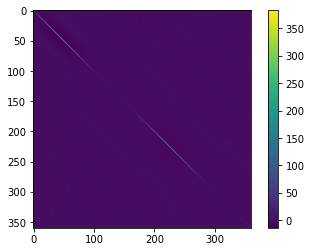

In [41]:
plt.imshow(Sigma)
plt.colorbar()
plt.show()

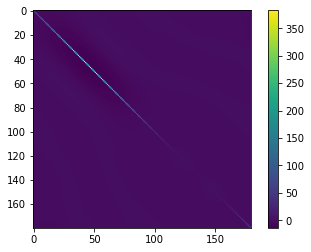

In [42]:
plt.imshow(Sigma_E)
plt.colorbar()
plt.show()

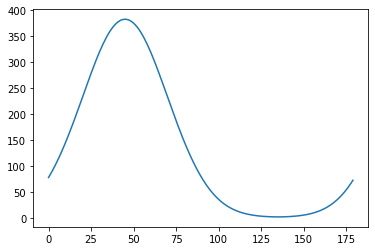

In [43]:
plt.plot(np.diag(Sigma_E))

In [44]:
np.linalg.matrix_rank(Sigma_E)

180

We compute the gain $\mathbf{G}_E = \frac{d\mathbf{r}_E}{ds}$ where $\mathbf{s}(\theta) = c\mathbf{h}(\theta)$.

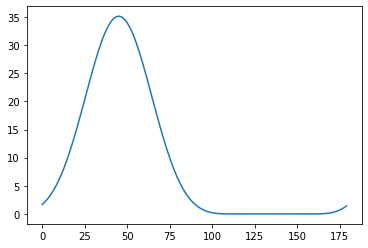

In [45]:
plt.plot(r_E_SS)

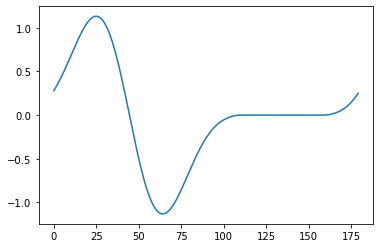

In [47]:
G_E = np.diff(r_E_SS, axis=0, append=r_E_SS[0,0])
plt.plot(G_E)
plt.show()

Fisher information computation for the E pop is $FI_E = \mathbf{G}_E^T \mathbf{\Sigma}_E^{-1}\mathbf{G}_E$:

In [48]:
FI_E = (((G_E.T)@Sigma_E_inv@G_E).flatten())[0]
print(f'FI_E = {FI_E}')

FI_E = 4.280354819772693


# Noisy simulation

In [15]:
def noisy_integrate(t0, T, dt, phi, N, Ne, Ni, tau_E, tau_I, J_EE, J_II, J_EI, J_IE, sigma_ori, sigma_FF, k, n, c, tau_n, c_ne, c_ni):
    r_E = np.zeros((Ne,1)) # firing rate vector of E neurons
    r_I = np.zeros((Ni,1)) # firing rate vector of I neurons
    zero = np.zeros((N,1)) # Nx1 zero vector
    
    xs = np.linspace(0, N-1, N)
    
    xe = np.zeros((Ne,1))
    xi = np.zeros((Ni,1))
    
    R_E = r_E # these will store firing rates at each timestep as columns
    R_I = r_I 
    
    G_ori = np.fromfunction(lambda x,y: gaussian(x,y,sigma_ori), (N,N)) # connectivity matrix G
    h = np.array([hfunc(x, phi, sigma_FF) for x in range(N)]) # has shape (180,)
    h = h[:,None] # makes shape (180,1)
    
    W_EE = J_EE*G_ori
    W_EI = -J_EI*G_ori
    W_IE = J_IE*G_ori
    W_II = -J_II*G_ori
    
    I_E = c*h + W_EE@r_E + W_EI@r_I # initial inputs 
    I_I = c*h + W_IE@r_E + W_II@r_I
    
    M = int(T/dt)
    ts = np.arange(M+1)
    
    for m in range(M):
        # smoothed white noise process
        n_e = np.random.randn(Ne,1)
        n_i = np.random.randn(Ni,1)
        xe = xe + (1/tau_n)*(-xe*dt + np.sqrt(2*tau_n*dt)*n_e)
        xi = xi + (1/tau_n)*(-xi*dt + np.sqrt(2*tau_n*dt)*n_i)

        r_E = r_E + dt*(1/tau_E)*(-r_E + xfer(k, n, I_E))
        r_I = r_I + dt*(1/tau_I)*(-r_I + xfer(k, n, I_I))

        I_E = c*h + W_EE@r_E + W_EI@r_I + c_ne*xe
        I_I = c*h + W_IE@r_E + W_II@r_I + c_ni*xi

        rE_SS = k*(np.power((np.maximum(I_E, zero)), n))
        rI_SS = k*(np.power((np.maximum(I_I, zero)), n))
        R_E = np.c_[R_E, r_E]
        R_I = np.c_[R_I, r_I]
        
    return r_E, r_I, R_E, R_I, xs, ts, c, h, W_EE, W_EI, W_IE, W_II, tau_n, c_ne, c_ni

In [16]:
r_E_n, r_I_n, R_E_n, R_I_n, xs, ts, c, h, W_EE, W_EI, W_IE, W_II, tau_n, c_ne, c_ni = noisy_integrate(t0=0, T=5000, dt=0.1, phi=45, N=180, Ne=180, Ni=180, tau_E=20, tau_I=10, J_EE=0.044, J_II=0.018, J_EI=0.023, J_IE=0.042, sigma_ori=32, sigma_FF=30, k=0.04, n=2.0, c=40, tau_n=1, c_ne=1, c_ni=1)


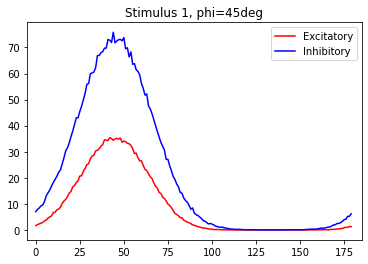

In [17]:
plt.plot(xs, r_E_n, label='Excitatory', color='r')
plt.plot(xs, r_I_n, label='Inhibitory', color='b')
plt.title('Stimulus 1, phi=45deg')
plt.xlim(-5,185)
plt.legend()
plt.show()

In [18]:
def xcov(x,y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    return signal.correlate(x-xbar, y-ybar, mode='full')

## Some plots of the time series

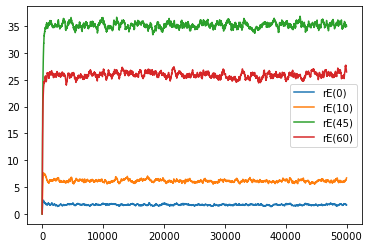

In [19]:
plt.plot(R_E_n[0,:], label='rE(0)')
plt.plot(R_E_n[10,:], label='rE(10)')
plt.plot(R_E_n[45,:], label='rE(45)')
plt.plot(R_E_n[60,:], label='rE(60)')
plt.legend()
plt.plot
plt.show()

Before computing cross-covariances, we have to clip the transients. Based on the time series plots, it seems like clipping the first 500 timesteps works.

In [20]:
R_E_n = R_E_n[:,500:]
R_I_n = R_I_n[:, 500:]

Next, do some checks that the means of the rates from the noisy sim match the steady-state rates from the deterministic sim:

In [21]:
np.mean(R_E_n[0,:])

1.7072279564066901

In [22]:
r_E_SS[0,0]

1.6693528215048052

In [23]:
np.mean(R_E_n[45,:])

35.165481153084556

In [24]:
r_E_SS[45,0]

35.126691306868025

In [25]:
np.mean(R_E_n[165,:])

0.07219233373055109

In [26]:
r_E_SS[165,0]

0.03243455755511907

## Covariance plots

First, we compare plots of the covariance computed from the noisy sim with the covariance matrix computed via linear theory:

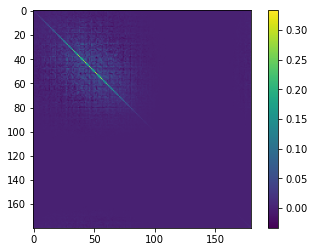

In [64]:
# covariance from noisy sim
plt.imshow(np.cov(R_E_n))
plt.colorbar()
plt.show()

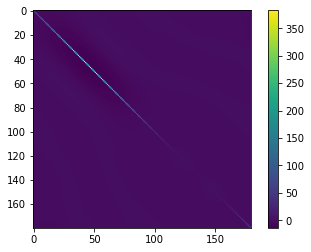

In [63]:
# covariance from linear theory
plt.imshow(Sigma_E)
plt.colorbar()
plt.show()

## Plots of cross-covariance functions

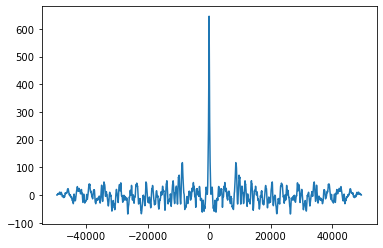

In [31]:
plt.plot(np.arange(-R_E_n[0,:].shape[0]+1, R_E_n[0,:].shape[0]), xcov(R_E_n[0,:], R_E_n[0,:]))
plt.show()

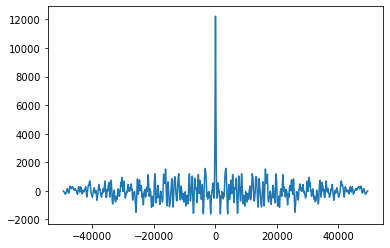

In [28]:
plt.plot(np.arange(-R_E_n[35,:].shape[0]+1, R_E_n[35,:].shape[0]), xcov(R_E_n[35,:], R_E_n[35,:]))
plt.show()

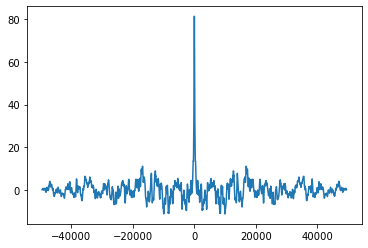

In [57]:
plt.plot(np.arange(-R_E_n[170,:].shape[0]+1, R_E_n[170,:].shape[0]), xcov(R_E_n[170,:], R_E_n[170,:]))
plt.show()

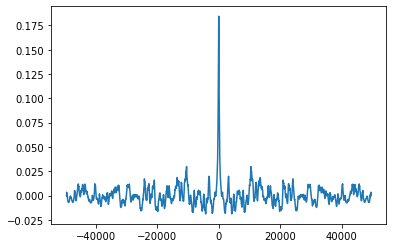

In [29]:
plt.plot(np.arange(-R_E_n[120,:].shape[0]+1, R_E_n[120,:].shape[0]), xcov(R_E_n[120,:], R_E_n[120,:]))
plt.show()